In [1]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
import keras_tuner as kt

/Users/tonghuang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# 1.Introduction and Problem Statement

In today's digital age, financial fraud has become a common problem that financial institutions struggle to cope with. Machine learning techniques can play a significant role in detecting fraudulent activities by learning from past transaction patterns.

The goal of our project is to build models that can predict whether a transaction is fraudulent or not. The project involves the use of three machine learning algorithms: Random Forest, SVM and a Neural Network for this task.

The data we are using is a simulated credit card transaction dataset, containing legitimate and fraudulent transactions.It was generated using the Sparkov Data Generation tool created by Brandon Harris, with both training and testing datasets provided.The simulation took place from 1st January 2019 to 31st December 2020, covering credit card transactions of 1000 customers with 800 merchants. Each instance in the dataset represents a transaction, with features like transaction amount, location, date and time of transaction, etc. The target variable we're trying to predict is a binary feature indicating whether the transaction is fraudulent or not.

# 2.Preprocessing data

We performed several preprocessing steps before feeding the data into the machine learning models:

The data was sorted based on credit card number and transaction time.

A new feature, 'dist_merch_prev', was created which represents the distance between the current transaction merchant and the previous one.

Days of the week and age of the cardholder were extracted from the transaction date and date of birth respectively.

Some columns that were not useful for the modeling purpose, like 'trans_date_trans_time', 'cc_num', 'first', etc., were dropped.

Also some colums that were hard to encode ,like'job','city',etc.,were dropped.

The categorical features were one-hot encoded and numerical features were standardized.

In [3]:
train = pd.read_csv('fraudTrain.csv')
test = pd.read_csv('fraudTest.csv')

In [4]:
train['dataset'] = 'train'
test['dataset'] = 'test'

In [5]:
data = pd.concat([train,test], axis = 0)
data.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,dataset
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,train


In [6]:
data.shape

(1852394, 24)

In [7]:
data[data.isnull().any(axis=1)].shape

(0, 24)

 There are no missing values in the data.

In [8]:
def calculate_distance(lat1, lon1, lat2, lon2):
    distance = ((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2) ** 0.5
    return distance

data = data.sort_values(['cc_num', 'unix_time'])

data['prev_merch_lat'] = data.groupby(by = ['cc_num'])['merch_lat'].shift(1)
data['prev_merch_long'] = data.groupby(by = ['cc_num'])['merch_long'].shift(1)

data['prev_merch_lat'].fillna(data['merch_lat'], inplace=True)
data['prev_merch_long'].fillna(data['merch_long'], inplace=True)

data['dist_merch_prev'] = calculate_distance(data['merch_lat'], data['merch_long'], data['prev_merch_lat'], data['prev_merch_long'])

data['dist_merch_prev'].head()

1017    0.000000
2724    2.076668
2726    0.949365
2882    0.839911
2907    1.275471
Name: dist_merch_prev, dtype: float64

Calculating the Euclidean distance between the current and previous merchant locations for each transaction.

In [9]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['trans_day_of_week'] = data['trans_date_trans_time'].dt.dayofweek
data['trans_day_of_week'].head()

1017    1
2724    2
2726    2
2882    2
2907    2
Name: trans_day_of_week, dtype: int32

Creating a new column 'trans_day_of_week', which represents the day of the week for each transaction.

In [10]:
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = ((data['trans_date_trans_time'] - data['dob']).dt.days / 365.25).astype(int)
data['age'].head()

1017    32
2724    32
2726    32
2882    32
2907    32
Name: age, dtype: int64

Creating a new column 'age',which represents the age of the card holder.

In [11]:
cols_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 
                'dob','merchant','zip','trans_num','lat','unix_time',
               'long','merch_lat','merch_long','prev_merch_lat','prev_merch_long','city','job']
new_data = data.drop(cols_to_drop, axis=1)
new_data.head()

,category,amt,gender,state,city_pop,is_fraud,dataset,dist_merch_prev,trans_day_of_week,age
1017,misc_net,7.27,F,WY,1645,0,train,0.000000,1,32
2724,gas_transport,52.94,F,WY,1645,0,train,2.076668,2,32
2726,gas_transport,82.08,F,WY,1645,0,train,0.949365,2,32
2882,kids_pets,34.79,F,WY,1645,0,train,0.839911,2,32
2907,home,27.18,F,WY,1645,0,train,1.275471,2,32


 Removing columns that are not useful for the subsequent modeling process.

In [12]:
train = new_data[new_data['dataset'] == 'train'].drop('dataset', axis=1)
test = new_data[new_data['dataset'] == 'test'].drop('dataset', axis=1)
train.reset_index(drop=True, inplace = True)
test.reset_index(drop=True, inplace = True)

X_train_raw = train.drop('is_fraud', axis=1)
X_test_raw = test.drop('is_fraud', axis=1)

y_train = train['is_fraud']
y_test = test['is_fraud']

Splitting the preprocessed data back into separate train and test datasets.

In [17]:
categorical_cols = ['category', 'gender', 'state']
numeric_cols = ['amt', 'city_pop', 'dist_merch_prev', 'trans_day_of_week', 'age']

preprocessing = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse = False), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ])

X_train = preprocessing.fit_transform(X_train_raw)
X_test = preprocessing.transform(X_test_raw)

/Users/tonghuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Applying the columntransformer to both the train and test sets.

# 3.Model Building

Three models were built for the purpose of this study:

Hanjiang Xue implemented RandomForest.

Tong Huang implemented SVM.

We implemented Neural Network together.

### (i) Random Forest 

A Random Forest model was built with 100 trees，a maximum depth of 5 and "class_weight="balanced" to help handle unbalanced classes..Further, the parameters of the model were fine-tuned using RandomizedSearchCV.

In [13]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=5,n_jobs=-1,
                                random_state=42,class_weight="balanced")

In [14]:
scores = cross_val_score(rf_clf, X_train, y_train, cv=3)
print("Average cross-validation score on train:",scores.mean())

Average cross-validation score on train: 0.9716312877166599


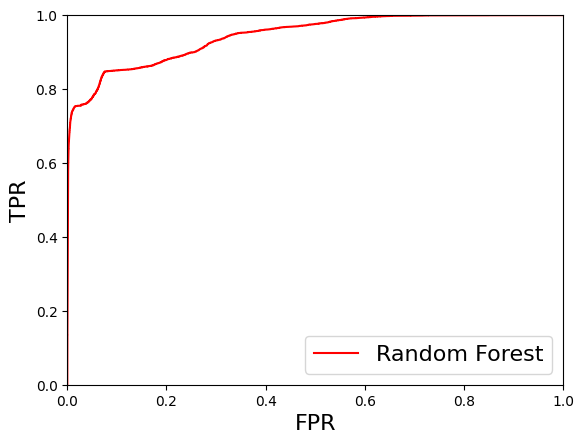

In [15]:
rf_clf.fit(X_train, y_train)
y_scores_train = rf_clf.predict_proba(X_train)
y_scores_train = y_scores_train[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_train)

plt.plot(fpr_rf, tpr_rf, "r-", label="Random Forest")
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

In [16]:
auc_score = roc_auc_score(y_train, y_scores_train)
print("Train ROC AUC: ", auc_score)

Train ROC AUC:  0.944285545193628


In [17]:
param_distribs = {
    'n_estimators': [200, 300,400],
    'max_depth': [5, 10, 20],
}

X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

rf = RandomForestClassifier(random_state=42,class_weight="balanced")

rnd_search = RandomizedSearchCV(rf, param_distribs, cv=3,n_iter=8, n_jobs=-1,scoring='roc_auc', random_state=42)
rnd_search.fit(X_train_sample, y_train_sample)

print("Best parameters: ", rnd_search.best_params_)
print("Best score: ", rnd_search.best_score_)

Best parameters:  {'n_estimators': 400, 'max_depth': 20}
Best score:  0.991005524667996


In [23]:
best_rf_clf = rnd_search.best_estimator_
y_scores_test = best_rf_clf.predict_proba(X_test)
y_scores_test = y_scores_test[:, 1]
auc_score_test = roc_auc_score(y_test, y_scores_test)
print("Test ROC AUC: ", auc_score_test)

Test ROC AUC:  0.9900052250422753


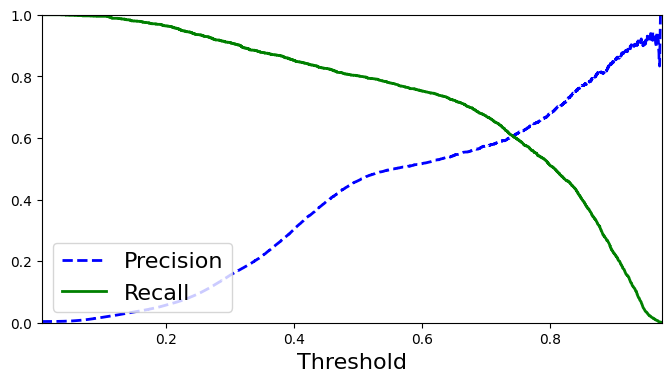

In [21]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="lower left", fontsize=16)
    plt.ylim([0, 1])
    
plt.figure(figsize=(8, 4))
precisions, recalls, thresholds = precision_recall_curve(y_test,y_scores_test)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()

In [24]:
y_pred_test = best_rf_clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.46      0.80      0.59      2145

    accuracy                           1.00    555719
   macro avg       0.73      0.90      0.79    555719
weighted avg       1.00      1.00      1.00    555719



### (iii) Neural Network

A Neural Network model was built using Keras Tuner for hyperparameter optimization. The model consists of an Input Layer followed by a Batch Normalization layer, several Dense layers with ReLU activation, and a final Dense layer with Sigmoid activation. 

In [17]:
X_train = preprocessing.fit_transform(X_train_raw).toarray()
X_test = preprocessing.transform(X_test_raw).toarray()
X_train_sample, X_valid, y_train_sample, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=5)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    dropout_rate = hp.Float('dropout_rate', 0, 0.5, step=0.1)
    kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2", 1e-4, 1e-1, sampling="log"))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=X_train_sample.shape[1:]))
    model.add(tf.keras.layers.BatchNormalization())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons,kernel_regularizer=kernel_regularizer, activation="relu"))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["AUC"])
    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials=10, 
                        seed=42,
                        overwrite=True,
                        directory="C:\\Users\\xhj62",
                        project_name='my_rnd_search')

tuner.search(X_train_sample, y_train_sample, epochs=10, validation_data=(X_valid, y_valid))

best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 10 Complete [00h 21m 22s]
val_loss: 0.025771094486117363

Best val_loss So Far: 0.02379993349313736
Total elapsed time: 03h 20m 26s
INFO:tensorflow:Oracle triggered exit
Trial 04 summary
Hyperparameters:
n_hidden: 5
n_neurons: 45
learning_rate: 0.0008960175671873151
dropout_rate: 0.2
l2: 0.00016308979287756595
Score: 0.02379993349313736


Epoch 1/10
40522/40522 - 182s - loss: 0.0238 - auc: 0.8917 - val_loss: 0.0264 - val_auc: 0.8760 - lr: 0.0100 - 182s/epoch - 4ms/step
Epoch 2/10
40522/40522 - 184s - loss: 0.0236 - auc: 0.8949 - val_loss: 0.0253 - val_auc: 0.8950 - lr: 0.0089 - 184s/epoch - 5ms/step
Epoch 3/10
40522/40522 - 184s - loss: 0.0236 - auc: 0.8938 - val_loss: 0.0243 - val_auc: 0.9210 - lr: 0.0079 - 184s/epoch - 5ms/step
Epoch 4/10
40522/40522 - 184s - loss: 0.0233 - auc: 0.8977 - val_loss: 0.0248 - val_auc: 0.9107 - lr: 0.0071 - 184s/epoch - 5ms/step
Epoch 5/10
40522/40522 - 182s - loss: 0.0231 - auc: 0.8987 - val_loss: 0.0267 - val_auc: 0.8680 - lr: 0.0063 - 182s/epoch - 4ms/step
Epoch 6/10
40522/40522 - 182s - loss: 0.0228 - auc: 0.9028 - val_loss: 0.0354 - val_auc: 0.6894 - lr: 0.0056 - 182s/epoch - 4ms/step
Epoch 7/10
40522/40522 - 183s - loss: 0.0226 - auc: 0.9039 - val_loss: 0.0257 - val_auc: 0.9086 - lr: 0.0050 - 183s/epoch - 5ms/step
Epoch 8/10
40522/40522 - 183s - loss: 0.0226 - auc: 0.9030 - val_loss

<Figure size 600x400 with 0 Axes>

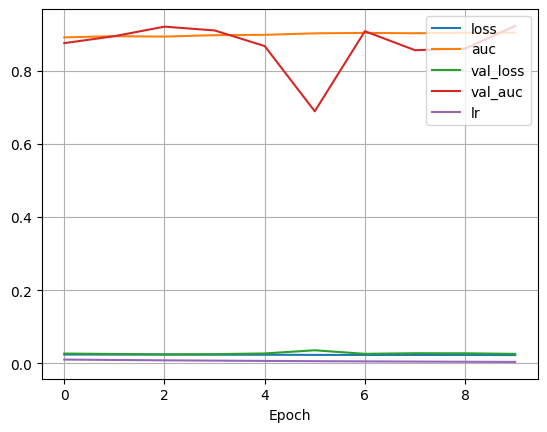

In [26]:
def exponential_decay(lr0, s):
    return lambda epoch: lr0 * 0.1**(epoch / s)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay(lr0=0.01, s=20))
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_auc', mode='max')

best_model = tuner.get_best_models(num_models=1)[0]
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
best_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["AUC"])

history = best_model.fit(X_train, y_train, epochs=10,
                         validation_data=(X_valid, y_valid),verbose=2, callbacks=[early_stopping_cb, lr_scheduler])

plt.figure(figsize=(6, 4))
pd.DataFrame(history.history).plot(grid=True, xlabel="Epoch")
plt.legend(loc="upper right")
plt.show()

In [27]:
y_pred_probs = best_model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_probs)
print("Test ROC AUC: ", auc_score)

17367/17367 [==============================] - 42s 2ms/step
Test ROC AUC:  0.9697871499533066


In [29]:
y_pred = (y_pred_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.31      0.30      0.30      2145

    accuracy                           0.99    555719
   macro avg       0.65      0.65      0.65    555719
weighted avg       0.99      0.99      0.99    555719



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

### (V) Support Vector Machine

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform, loguniform
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np

X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.6, random_state=42)

In [119]:
standard = StandardScaler()
X_standard = standard.fit_transform(X_train_sample)

In [152]:
%%time
svc_clf1 = SVC(max_iter = 30000, class_weight = {0:1, 1:200}, random_state=42)

param_grid = {
    'C': uniform(0,10),
    'gamma': loguniform(0.0001, 0.1)
}

gridSearch = RandomizedSearchCV(svc_clf1, param_grid, cv = 3, n_iter = 5, n_jobs=-1, scoring = "roc_auc")
gridSearch.fit(X_standard, y_train_sample)

CPU times: user 24min 56s, sys: 14.5 s, total: 25min 11s
Wall time: 4h 15min 40s


/Users/tonghuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=SVC(class_weight={0: 1, 1: 200}, max_iter=30000,
                                 random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa5dc86d100>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fa5dc88c2b0>},
                   scoring='roc_auc')

In [157]:
print("The best training ROC AUC score is {}".format(gridSearch.best_score_))

The best training ROC AUC score is 0.9429360994078854


In [154]:
ypred = gridSearch.best_estimator_.predict(X_test_standard)

In [155]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    553574
           1       0.03      0.73      0.06      2145

    accuracy                           0.91    555719
   macro avg       0.51      0.82      0.50    555719
weighted avg       1.00      0.91      0.95    555719



### (VI) SGD Classifier

In [159]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(class_weight = "balanced", random_state=42)

params = {"alpha": loguniform(0.0001, 0.1)}

random_sgd_search = RandomizedSearchCV(sgd_clf, params, cv = 3, n_iter=5, n_jobs = -1, scoring = "roc_auc")
random_sgd_search.fit(X_train_sample, y_train_sample)

sgd_result = random_sgd_search.best_estimator_.predict(X_test)
print(classification_report(y_test, sgd_result))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    553574
           1       0.06      0.75      0.11      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719



In [162]:
print("The best training ROC AUC is {}".format(random_sgd_search.best_score_))

The best training ROC AUC is 0.8765353084852793


# 4.Conclusion

The goal of this project was to develop models that can predict the outcome of a binary event with high precision and recall. Three types of models were implemented: a Random Forest model, SVM model, a Deep Neural Network (DNN) model. All models were evaluated using various metrics including ROC AUC score, precision, recall, and the F1 score. In the context of detecting fraudulent transaction, recall(sensitivity) is particularly relevant because maximizing on identifying the fraudulent transcation is important.

From the results obtained, the Random Forest model performed exceptionally well with a training ROC AUC score of 0.944, a testing ROC AUC score of 0.990, and an average cross-validation score of 0.972. The precision for class 1 (minority class) was 0.46, and it had an impressive recall rate of 0.80. This indicates that the Random Forest model was able to predict the majority of the positive class instances correctly, though at the cost of a higher number of false positives .

On the other hand, the default DNN model, which contains one hidden layer with 50 neurons, had a testing ROC AUC score of 0.976. The precision for class 1 is 0.76 and the recall for class 1 is 0.56. The DNN model after hyperparameters optimization had a testing ROC AUC score of 0.88. The precision for the minority class in the DNN model was 0.26, with a recall of 0.46. It is surprising that the default DNN model performed better than the one after hyperparameter optimization. Compared to the Random Forest model, the default DNN model performed less efficiently in detecting the fraudulent transaction, but its predicted fraudulent transactions are likely to be true.

Support Vector Machine performs worse than other models. The training ROC AUC score of SVM is 0.94. The precision and the recall for class 1 are only 0.03 and 0.73. Altertively, the Stochastic Gradient Descent model is used for linear SVM. It had low precision of 0.06, but higher recall of 0.75. A potential resample for imbalanced data may help the model to improve. These scores are worse than both DNN and Random Forest.

In conclusion, the high recall score of the Random Forest model implies that it was able to correctly identify a high proportion of positive instances, making it the more reliable model for this particular binary classification task.